Now we use gplearn with a new set of features obtained by permutation feature importance analysis to fit a new mathematical formula correlating these features to the perovskite OER activities.

In [2]:
import numpy as np
import pandas as pd
from gplearn.genetic import SymbolicRegressor
from sklearn.metrics import mean_absolute_error
from collections import defaultdict

df = pd.read_excel("data_gp.xlsx")
X = df[['mu', 'mu/t', 'mu/RA', 't', 'XB', 'mu*t']].values
y = df['VRHE'].values

X_train = X[:18, :]
y_train = y[:18]
X_val = X[18:, :]
y_val = y[18:]

In [3]:
X_train, y_train

(array([[0.43      , 0.433     , 0.31617647, 0.993     , 1.55      ,
         0.42699   ],
        [0.422     , 0.423     , 0.31029412, 0.998     , 1.73      ,
         0.421156  ],
        [0.415     , 0.413     , 0.30514706, 1.003     , 1.91      ,
         0.416245  ],
        [0.437     , 0.442     , 0.32132353, 0.988     , 1.725     ,
         0.431756  ],
        [0.414     , 0.413     , 0.30441176, 1.004     , 1.902     ,
         0.415656  ],
        [0.413     , 0.412     , 0.30367647, 1.004     , 1.894     ,
         0.414652  ],
        [0.407     , 0.404     , 0.29926471, 1.009     , 1.83      ,
         0.410663  ],
        [0.407     , 0.403     , 0.2981685 , 1.01      , 1.83      ,
         0.41107   ],
        [0.407     , 0.402     , 0.29708029, 1.012     , 1.83      ,
         0.411884  ],
        [0.404     , 0.399     , 0.29705882, 1.011     , 1.88      ,
         0.408444  ],
        [0.398     , 0.394     , 0.29481481, 1.011     , 1.88      ,
         0.402378  ],

In [4]:
for pc in np.arange(0.5, 0.95, 0.05):
    for ps in np.arange((1-pc), (0.92-pc), -0.01):
        for parsimony in np.arange(0.0005, 0.0016, 0.0005):
            est_gp = SymbolicRegressor(population_size=3000, generations=20, stopping_criteria=0.01, p_crossover=pc, p_subtree_mutation=ps/3, 
            p_hoist_mutation=ps/3, p_point_mutation=1-pc-ps/3-ps/3, function_set=('add', 'sub', 'mul', 'div', 'sqrt'), 
            parsimony_coefficient=parsimony, tournament_size=20, metric='mean absolute error', const_range=(-1.0, 1.0))

            est_gp.fit(X_train, y_train)
            program = str(est_gp._program)
            length = est_gp._program.length_
            depth = est_gp._program.depth_
            y_pred = est_gp.predict(X_train)
            mae = mean_absolute_error(y_train, y_pred)

            with open("program_length_depth_mae.txt", "a") as f:
                f.write(f"pc: {pc}   ps: {ps/3}   ph: {ps/3}   pp: {1-pc-ps/3-ps/3}   p_coef: {parsimony}   {program}   length: {length}   depth: {depth}   mae: {mae}\n")

/global/homes/y/yeming/anaconda3/envs/ML-env/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/global/homes/y/yeming/anaconda3/envs/ML-env/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/global/homes/y/yeming/anaconda3/envs/ML-env/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warn

In [5]:
# Input and output file paths
input_file = "program_length_depth_mae.txt"
output_file_depth = "grouped_programs_depth.txt"
output_file_length = "grouped_programs_length.txt"

grouped_lines_length = defaultdict(list)
grouped_lines_depth = defaultdict(list)

# Read and group lines based on length
with open(input_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        key = parts[-5]
        grouped_lines_length[key].append(line)

# Read and group lines based on depth
with open(input_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        key = parts[-3]
        grouped_lines_depth[key].append(line)

# Sort lines based on the MAE value in each group
def extract_last_number(line):
    return float(line.strip().split()[-1])  # convert last token to float

for key in sorted(grouped_lines_length):
    grouped_lines_length[key] = sorted(grouped_lines_length[key], key=extract_last_number)

for key in sorted(grouped_lines_depth):
    grouped_lines_depth[key] = sorted(grouped_lines_depth[key], key=extract_last_number)

# Write grouped lines to output
with open(output_file_length, "w") as f:
    for key in sorted(grouped_lines_length):  # or just use grouped_lines if order doesn't matter
        f.writelines(grouped_lines_length[key])

with open(output_file_depth, "w") as f:
    for key in sorted(grouped_lines_depth):  # or just use grouped_lines if order doesn't matter
        f.writelines(grouped_lines_depth[key])

The results will be stored in grouped_programs_length.txt and grouped_programs_depth.txt as sorted by formula length and depth, respectively.

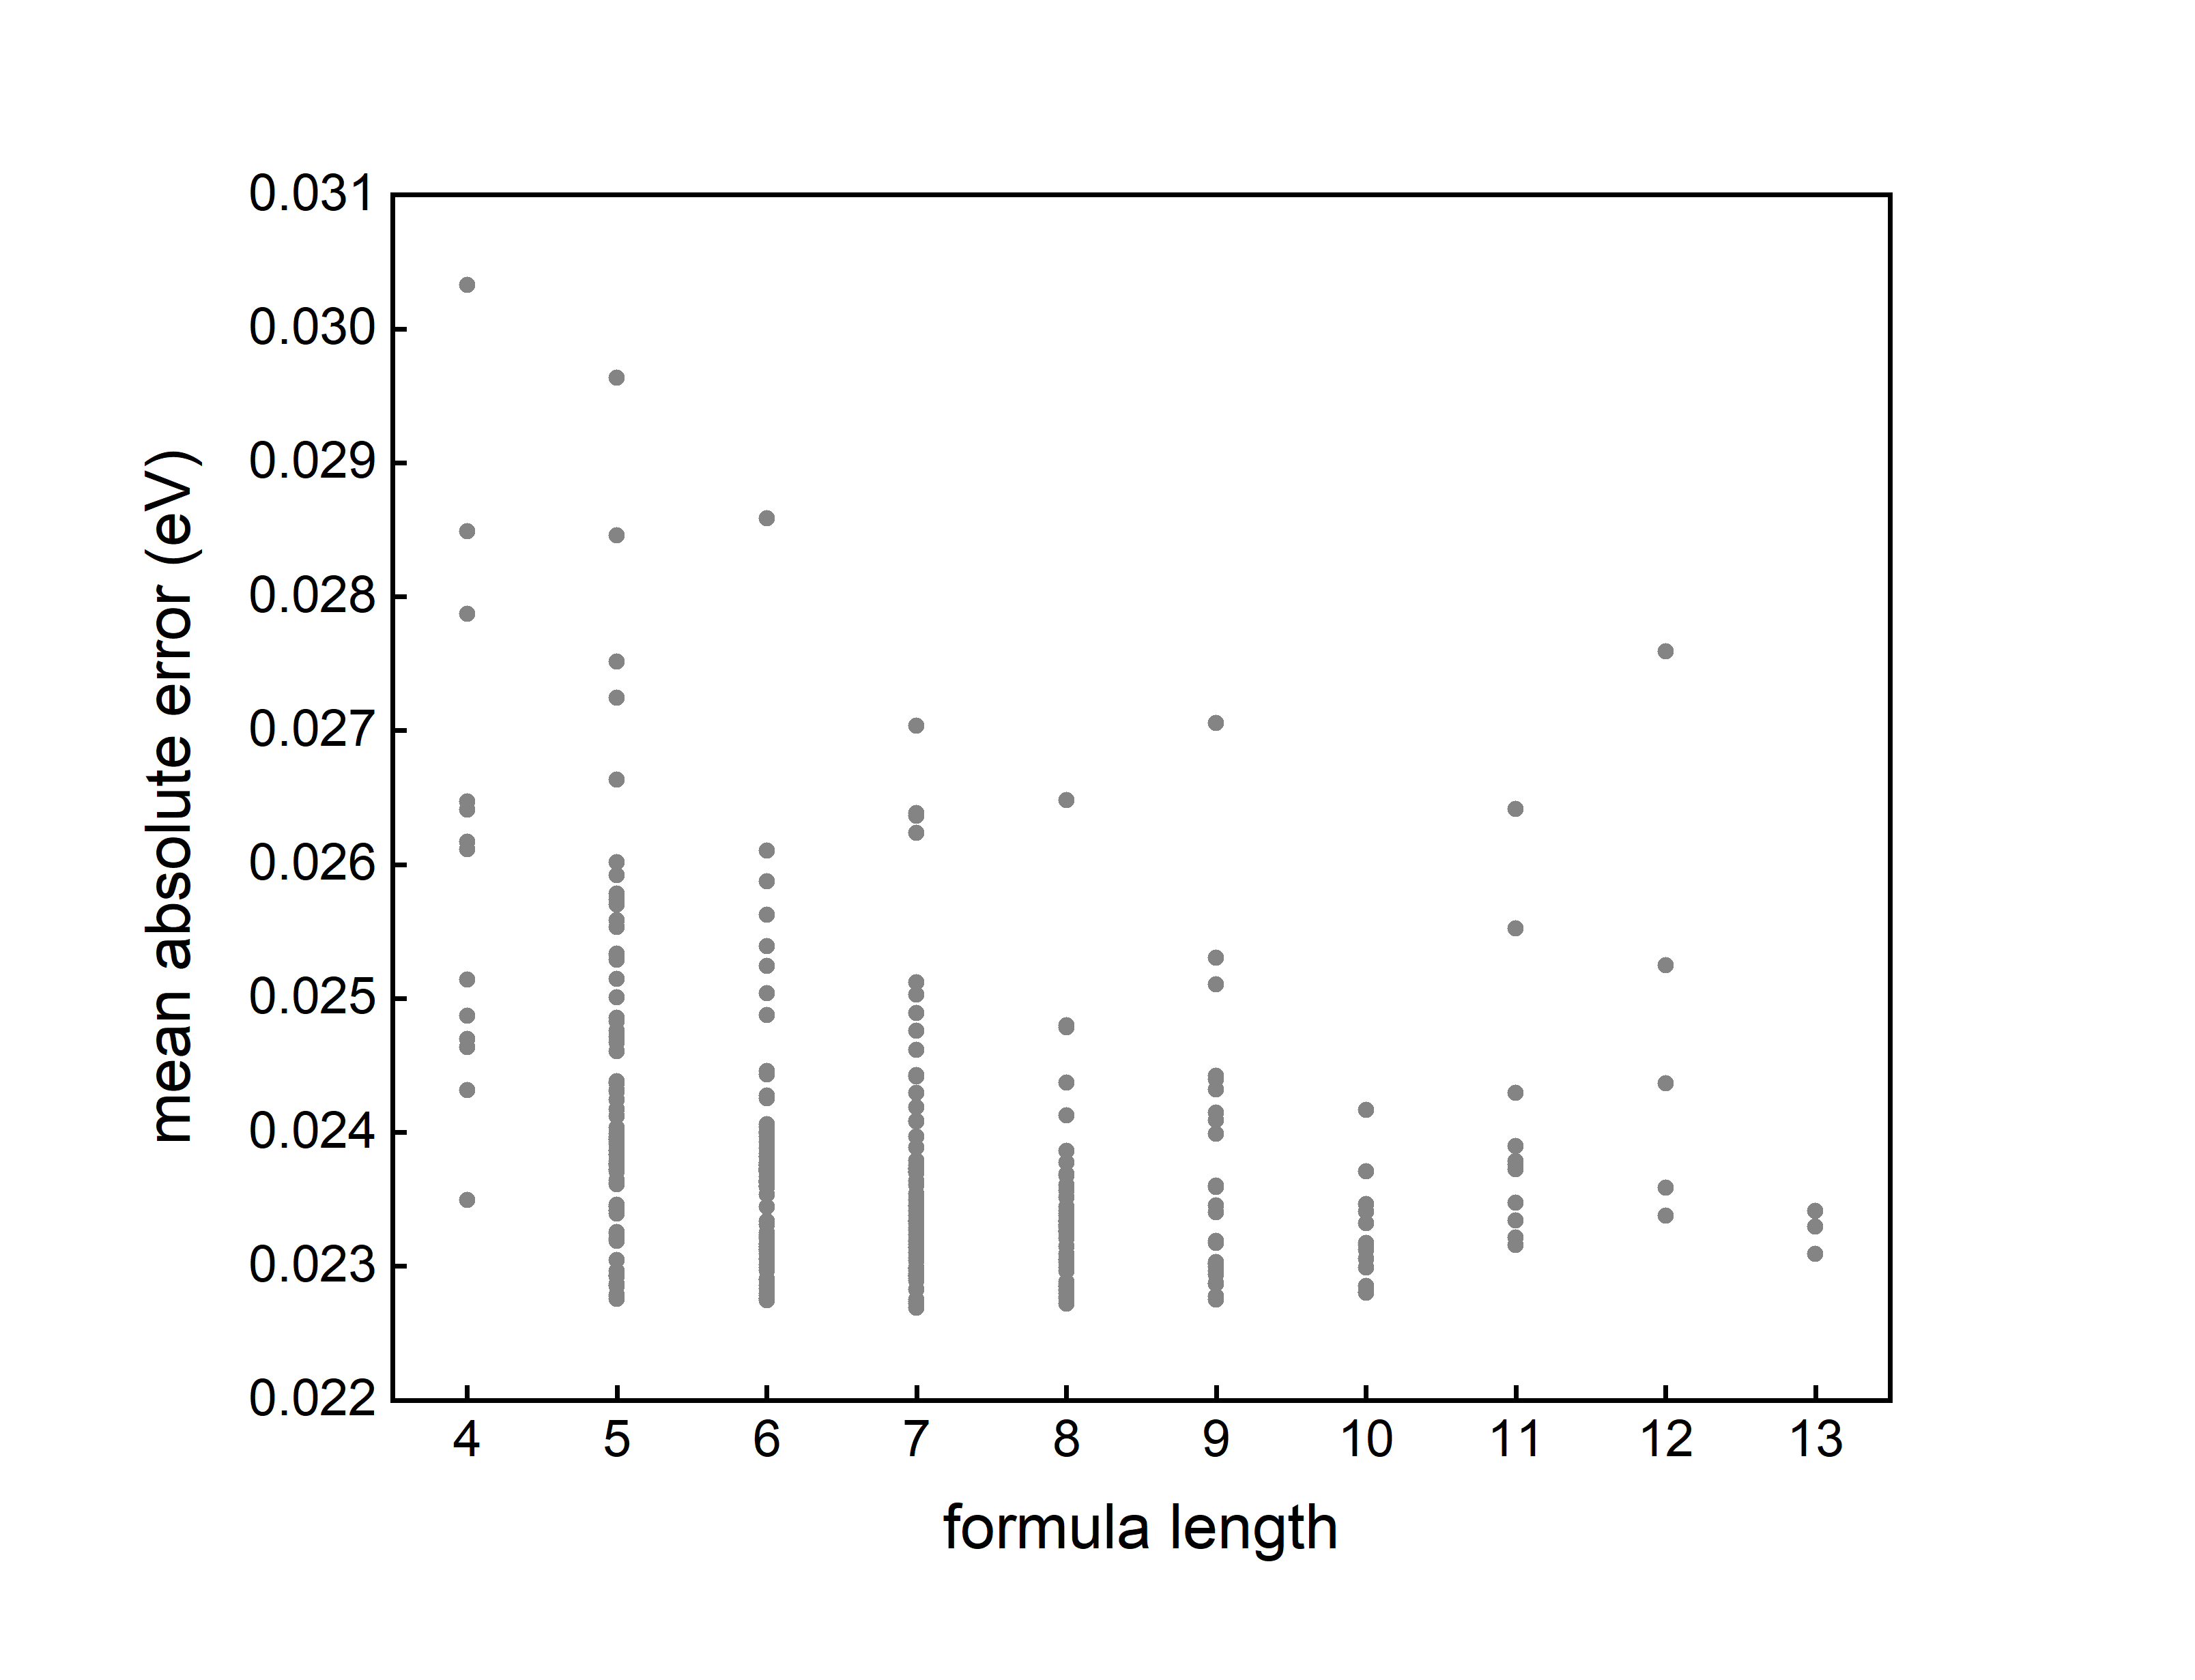

In [1]:
from IPython.display import Image
Image(filename='MAE_vs_length.png', width=500)

This MAE vs formula length plot shows the distribution of MAE of the generated formulas in each formula length catagories. The following shows the formulas with the lowest MAE in each catagory.

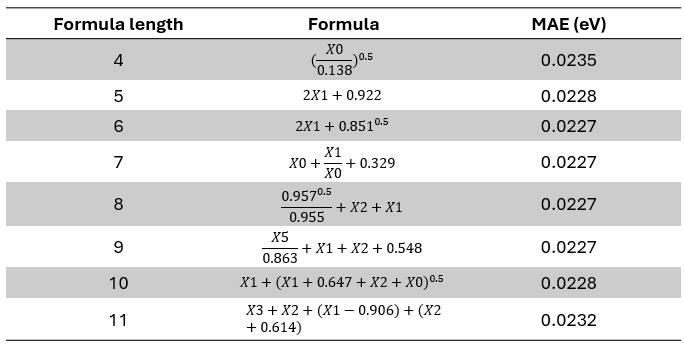

In [2]:
Image(filename='formulas.png', width=500)

We select formula with length 6 as trade-off between accuracy and complexity, X1 denotes mu/t. Such formula aligns well in the form with the formula found in the perovskite OER paper despite some discrepancy in the constant.